# Modelowanie statystyczne

## Tematy
- Podsumowanie regresji liniowej na wysokim poziomie
- składnia R 
- Zasady modelu regresji
- Pozostałości
- Relacje nieliniowe
- Korelacja
- Współczynniki i współczynniki interpretacji
- Znajdowanie odpowiednich funkcji/Usuwanie nieistotnych terminów
- Zmienne kategorialne
- Interakcje
- Normalność
- Transformacje władzy

Chociaż powyższe cele nauczania wydają się wskazywać, że jest to długi i złożony notatnik – tak nie jest. Jest to jednak jeden z najważniejszych notatników w tym rozdziale, ponieważ zapewnia rygorystyczne ramy do analizy danych. Zrobiłem co w mojej mocy, aby podać tutaj informacje w zwięzły i intuicyjny sposób, unikając przeciążenia matematyką, chyba że jest to podstawą zrozumienia problemu.

Będziemy pracować głównie w kolejności opisanej w celach nauczania, zaczynając od prostego zestawu danych, aby zilustrować problemy/wyzwania, zanim przejdziemy do bardziej realistycznych zestawów danych. Wszystkie te problemy są przedstawione pod parasolem regresji liniowej. W przypadku regresji logistycznej lub klasyfikacji wieloklasowej NIEKTÓRE z tych technik mają mniejsze zastosowanie. Podobnie, chociaż założenia dla modelu regresji liniowej nie są takie same jak w przypadku modeli opartych na drzewie wprowadzonych wcześniej, podczas pracy z modelami opartymi na drzewie zalecam wykonanie odpowiednich metodologii, ponieważ będą one
1. pomóc lepiej zrozumieć Twoje dane
2. pomóż zwiększyć metryki swoich modeli.

Ponadto istnieje wiele bibliotek z szeroką gamą składni modeli statystycznych. Z jedną z tych bibliotek (sklearn) zapoznaliśmy się w rozdziale 1. Tutaj przedstawię inną bibliotekę, `statsmodels`, ponieważ pozwala nam ona używać składni podobnej do **R** do definiowania naszych modeli. Wybrałam to z trzech powodów:
1. Jest to potężny, zwięzły i wyrazisty sposób definiowania zmiennych istotnych dla Twojego modelu.
2. R jest jedną z najpopularniejszych bibliotek Data Science/Statistics. Chociaż nie omawiamy R na tym przedmiocie, delikatne wprowadzenie do niektórych elementów jego składni może okazać się warte zachodu, jeśli kiedykolwiek będziesz musiał z nim pracować.
3. Programowanie! Większa ekspozycja na wiele bibliotek zostanie zakorzeniona, gdy właściwa rzecz do użycia w danej sytuacji

## Przypomnienie regresji liniowej

Być może najbardziej podstawową formą regresji liniowej jest:
$$
\hat{y}_i = \beta_Wx_i + \beta_b + \epsilon_i
$$

Gdzie $x$ jest jedną zmienną objaśniającą, która zawiera wiele próbek wyliczonych przez $i$. $\hat{y}_i$ jest zmienną zależną dla zmiennej $i$-tej $x$. $\beta_W$ i ​​$\beta_b$ to odpowiednio sparametryzowane wagi i obciążenia, wyuczone podczas dopasowywania modelu. Zmienna $\epsilon$ może nie została wcześniej wprowadzona, ale oznacza błąd losowy/nieodłączny w próbkach. Za chwilę przedstawimy konceptualizację.

Jako prosty przykład demonstrujący koncepcje, które zostaną wprowadzone, będziemy pracować z zestawem danych dotyczących zasięgu lodu morskiego na Arktyce, przyglądając się wartościom rocznym. Pełne dane można znaleźć [tutaj](https://nsidc.org/data/seaice_index/archives). Tutaj wyodrębniłam dane, które są istotne dla tego ćwiczenia, w szczególności miesięczne dane z września dla Arktyki do roku 2012.

In [22]:
import pandas as pd

years_range = list(range(1979, 2013))
# Extent is of unit millions of square km
extent = [7.05, 7.67, 7.14, 7.3, 7.39, 6.81, 6.7, 7.41, 7.28, 7.37, 7.01, 6.14, 6.47, 7.47, 6.4, 7.14, 6.08, 7.58, 6.69, 6.54, 6.12, 6.25, 6.73, 5.83, 6.12, 5.98, 5.5, 5.86, 4.27, 4.69, 5.26, 4.87, 4.56, 3.57]

ice_df = pd.DataFrame(list(zip(years_range, extent)), columns=["Year", "Extent"])
ice_df

,Year,Extent
0,1979,7.05
1,1980,7.67
2,1981,7.14
3,1982,7.30
4,1983,7.39
5,1984,6.81
6,1985,6.70
7,1986,7.41
8,1987,7.28
9,1988,7.37


We'll start by plotting the data:

In [23]:
import plotly.express as px

px.scatter(ice_df, "Year", "Extent", title="Year vs Sea Ice Extent (Million sq KM)")

Ok, więc widzimy silny trend spadkowy - wygląda na to, że moglibyśmy to wymodelować linią prostą, więc spróbujmy prostej regresji liniowej, aby określić, czy spadek jest istotny statystycznie. Użyjemy regresji zwyczajnych najmniejszych kwadratów, która jest rodzajem regresji liniowej, która została przedstawiona w rozdziale 1.

Aby wyjaśnić wprowadzone wcześniej $\epsilon$, zauważ, że wartości tych danych są jedną z wielu próbek lodu morskiego, które mogły zostać pobrane. Te wartości zostały pobrane w dowolny dzień we wrześniu, ale rozumiemy, że gdyby dane zostały pobrane innego dnia, to wynikowe $W$ i $b$ byłyby nieco inne. Tak więc $W$ i $b$ nie są wartościami prawdziwymi, ale oszacowaniami ze skojarzonym z nimi *błędem*.

Nasz model populacji można zapisać jako: $y_i = Wx_i + b + \epsilon_i$ gdzie $W$ i $b$ to prawdziwe wagi i błędy systematyczne, oszacowane przez $\beta_W$ i ​​$\beta_b$ z naszych przykładowych danych. Tak jak zostało to wprowadzone wcześniej, powinniśmy pomyśleć o sformułowaniu hipotezy, aby uogólnić wyniki z naszej próby na populację.

- H0: W = 0. Nie ma liniowej zmiany ilości lodu morskiego na przestrzeni lat
- Ha: W $\neq$ 0. Ilość lodu morskiego zmienia się liniowo na przestrzeni lat

Świetny! Dopasujmy linię i przetestujmy naszą hipotezę. Jak wspomniano na początku tego notatnika, użyjemy biblioteki `statsmodels` i wprowadzimy nową składnię. Jako wprowadzenie do `statsmodels`, ich [podręcznik użytkownika](https://www.statsmodels.org/devel/user-guide.html) jest dość obszerny

Uwaga Nie *musimy* używać składni podobnej do R, aby używać `statsmodels`. W rzeczywistości jest obsługiwany tylko dzięki innej bibliotece o nazwie [Patsy](https://patsy.readthedocs.io/en/latest/). Jeśli podoba Ci się ta składnia i/lub potrzebujesz odniesienia, aby uzyskać więcej informacji, zdecydowanie sprawdź ich dokumentację!

Ogólna składnia formuły jest podana jako „Y ~ X1 + X2 + X3”, gdzie Y jest zmienną *endogeniczną* (tj. cel/odpowiedź/zależną), a różne X są różnymi *egzogenicznymi* (tj. zmiennymi objaśniającymi/projektowymi/niezależnymi)

In [24]:
import statsmodels.formula.api as smf

In [25]:
import statsmodels.formula.api as smf

model = smf.ols(formula="Extent ~ Year", data=ice_df).fit()
print(model.summary())
print(model.aic)

                            OLS Regression Results                            
Dep. Variable:                 Extent   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     77.68
Date:                Mon, 29 Jan 2024   Prob (F-statistic):           4.53e-10
Time:                        19:40:44   Log-Likelihood:                -27.953
No. Observations:                  34   AIC:                             59.91
Df Residuals:                      32   BIC:                             62.96
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    180.8159     19.797      9.134      0.0

Tak więc dla naszych danych o lodzie dopasowany model, który próbuje przewidzieć zasięg lodu morskiego w danym roku, jest podany jako:

$$
\hat{\text{Extent}} = 180,82 - 0,0874\text{Year}
$$

(w zakresie lat 1979 - 2012). Powyższy wzór oznacza, że dla każdego wzrostu o 1 rok następuje zmniejszenie zasięgu lodu morskiego o 0,0874. Innymi słowy, 87 400 km rocznie (ponieważ zasięg lodu morskiego zmierzono w milionach km kwadratowych). Użyjemy atrybutu `.fittedvalues`, aby wyodrębnić naszą linię, którą następnie wykreślimy za pomocą Plotly.

Uwaga Moglibyśmy użyć Plotly Express do wykreślenia tych modeli, ale API `graph_objects` Plotly będzie prawdopodobnie nieco wygodniejsze w obsłudze.

In [26]:
import plotly.graph_objects as go

ice_df["fitted"] = model.fittedvalues

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=ice_df["Year"], y=ice_df["Extent"], name="Year vs Sea Ice Extent (million sq km)", mode="markers"))
fig.add_trace(go.Scatter(
    x=ice_df["Year"], y=ice_df["fitted"], name="Fitted Regression Line"))
fig.update_layout(title="Regression line of Year vs Sea Ice Extent (million sq km)", xaxis_title="Year",
    yaxis_title="Sea Ice Extent")
fig.show()

Krótko mówiąc, Intercept nie ma sensu, ponieważ wykracza poza zakres danych. Powinniśmy przedefiniować zmienną Year taką, jaka jest, odjęta przez najwcześniejszy rok (1979), więc nasza oś x zaczyna się od 0.

In [27]:
ice_df["YearAdj"] = ice_df["Year"] - 1979
model = smf.ols(formula="Extent ~ YearAdj", data=ice_df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Extent   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     77.68
Date:                Mon, 29 Jan 2024   Prob (F-statistic):           4.53e-10
Time:                        19:40:44   Log-Likelihood:                -27.953
No. Observations:                  34   AIC:                             59.91
Df Residuals:                      32   BIC:                             62.96
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.7736      0.190     40.819      0.0

Jak widać, punkt przecięcia jest teraz naturalnie bardziej interpretowalny, podczas gdy współczynnik pozostaje taki sam

In [28]:
import plotly.graph_objects as go

In [29]:
import plotly.graph_objects as go

ice_df["fitted"] = model.fittedvalues

fig = go.Figure()
# Note that we still plot against the original Year variable
fig.add_trace(go.Scatter(
    x=ice_df["Year"], y=ice_df["Extent"], name="Year vs Sea Ice Extent (million sq km)", mode="markers"))
fig.add_trace(go.Scatter(
    x=ice_df["Year"], y=ice_df["fitted"], name="Fitted Regression Line"))
fig.update_layout(title="Regression line of Year vs Sea Ice Extent (million sq km)", xaxis_title="Year",
    yaxis_title="Sea Ice Extent")
fig.show()

Patrząc jeszcze raz na tabelę podsumowań, znajduje się kolumna o nazwie `P>|t|`. Jest to prawdopodobieństwo, że wartość współczynnika zostanie wylosowana ze sparametryzowanego rozkładu t. Nie zamierzam mówić werbalnie, w jaki sposób wykonuje się te obliczenia, ale poniższy spoiler prześledzi matematykę na wypadek, gdybyś był zainteresowany. Należy zwrócić uwagę na rzeczywistą wartość. (Niestety) Metoda `statsmodels` `.summary()` podaje wartość tylko do 3 miejsc po przecinku - wystarczy, aby sprawdzić, czy chcemy zachować, czy odrzucić hipotezę zerową. Jeśli jednak chcielibyśmy uzyskać rzeczywiste wartości p, możemy po prostu uruchomić atrybut `.pvalues` w modelu.

W każdym razie, jak widzimy, wartość p dla naszego współczynnika wyboru wynosi (w przybliżeniu) 0, czyli mniej niż nasz standardowy poziom istotności $\alpha = 0,05 $. Dlatego **możemy odrzucić hipotezę zerową** i stwierdzić, że ilość lodu morskiego zmienia się liniowo na przestrzeni lat.

<br>
<details>
    <summary><b> Kliknij tutaj, aby dowiedzieć się, jak obliczyć wartości p przy użyciu błędu standardowego</b></summary>
    <ul>
        <li>Najpierw dzielimy oszacowanie przez jego błąd standardowy, co daje nam wartość t. W tym przypadku -0,08743927/0,099207 = -8,814</li>
        <li>Ta wartość jest porównywana z rozkładem t z (n-p) stopniami swobody, gdzie n to liczba punktów danych, a p to liczba parametrów. Tutaj liczba punktów danych wynosi 34, a liczba parametrów wynosi 2. Zatem rozkład t będzie miał 32 stopnie swobody.</li>
        <li>Teraz musimy tylko wiedzieć, jakie jest prawdopodobieństwo, że t będzie większe lub równe 8,814 (wartość bezwzględna). Możemy to zrobić za pomocą klasy <a href="http://docs.scipy.org/doc/scipy/reference/tutorial/stats.html">stats</a> ze scipy: <code>stats.t. sf(abs_t_value, DoF)*2</code>, gdzie mnożymy przez 2, ponieważ nasz test jest dwustronny.
    </ul>
</details>

In [30]:
model.pvalues

Intercept    3.568248e-29
YearAdj      4.527915e-10
dtype: float64

In [31]:
print("Model P Values:", model.pvalues.values)
print("Model Coef:", model.params.values)
print("Model Std Errs:", model.bse.values)

from scipy import stats
t_val = model.params[1]/model.bse[1]
p_val = stats.t.sf(abs(t_val), len(ice_df)-2)*2
print()
print("Calculated P Value: ", p_val)

Model P Values: [3.56824788e-29 4.52791516e-10]
Model Coef: [ 7.77363025 -0.08743927]
Model Std Errs: [0.19044119 0.0099207 ]

Calculated P Value:  4.527915156456439e-10


## Zasady modelu regresji

Ok, więc właśnie użyliśmy modelu regresji liniowej. Ale nie omówiliśmy jeszcze założeń, które leżą u podstaw tego rodzaju modeli. Różne zasoby dadzą różną liczbę założeń, ale wszystkie mają swoje korzenie w tych czterech:
1. **Liniowość** związku między odpowiedzią a zmiennymi objaśniającymi
2. **Niezależność statystyczna reszt**. Oznacza to, że nie ma dostrzegalnego wzorca w resztach (lub nie ma korelacji między kolejnymi błędami w przypadku danych szeregów czasowych)
3. **Homeescedasyczność**. Skomplikowane słowo, ale nie skomplikowana definicja. Zasadniczo oznacza po prostu, że reszty mają stałą/bardzo podobną wariancję
4. **Normalność** rozkładu błędów.

W miarę postępów w tym notatniku będą one wprowadzane w bardziej formalny sposób. Jednak szybko zaczniemy, analizując składniki resztowe danych. Przypomnij sobie, że **reszta** jest po prostu błędem, który obliczyliśmy na *przykładowych* danych. Chociaż możesz zobaczyć, że są one używane zamiennie, technicznie rzecz biorąc, *błąd* jest terminem używanym do oznaczenia błędu obliczonego na danych dotyczących populacji.

In [32]:
# Creating a general plotting function for plotting a scatter plot and line on the same figure
def plot_scatter_and_line(x, scatter_y, line_y, scatter_name, line_name, title, x_title, y_title):

    fig = go.Figure()
    
    fig.add_trace(go.Scatter(
        x=x, y=scatter_y, name=scatter_name, mode="markers"))
    fig.add_trace(go.Scatter(
        x=x, y=line_y, name=line_name))
    fig.update_layout(title=title, xaxis_title=x_title,
        yaxis_title=y_title)
    
    return fig

In [33]:
ice_df["residuals"] = model.resid
# This is just a straight line at y = 0 so we can more easily discern positive and negative residuals
line_y = [0] * len(ice_df["Year"])
plot_scatter_and_line(ice_df["Year"], ice_df["residuals"], line_y, "Model residuals", "y=0", "Model Residual Plot of Year vs Ice Extent", "Year", "Residuals")

Na podstawie zasad, które opisaliśmy powyżej, nie można by Cię obwiniać za myślenie, że spełniliśmy kryteria 2 i 3 (porozmawiamy o kryteriach 1 dalej, a 4 później). Powiedziałabym, że te dane wykazują homoskedasywność (kryterium 3). Odnośnie kryterium 2 - statystyczna niezależność reszt, na pierwszy rzut oka wygląda na to, że reszty są niezależne. Jednak istnieje bardzo luźny wzorzec ujemnych reszt, po których następują dodatnie reszty, po których następuje ujemna, a następnie dodatnia. Może to wskazywać na pewną krzywiznę w związku – coś, co teraz zbadamy.

## „Nieliniowe”/Związki wielomianowe

Założenie prostoliniowo/liniowej relacji między dwiema zmiennymi może nie zawsze być poprawne. Biorąc pod uwagę ten zestaw danych dotyczących lodu, możemy spodziewać się pewnej krzywizny między zasięgiem lodu a rokiem (globalne ocieplenie jest bardziej powszechne w ostatnich latach). Możemy użyć regresji liniowej do modelowania relacji nieliniowych (np. wielomianu).

Zamierzam bardzo nieznacznie zmienić notacje na coś, czego możemy bardziej ogólnie używać w tym notebooku. $\beta$ ogólnie odnosi się do parametru. $\beta_b$ będzie odnosić się do obciążenia, podczas gdy $\beta_\cdot$ będzie odnosić się do pewnych odpowiednich wag/współczynników zmiennej objaśniającej. W tym zapisie moglibyśmy modelować zależność kwadratową jako (czy to przypomina $Y = ax^2 + bx + c$? 😉):

$$
\hat{y_i} = \beta_1x_i^2 + \beta_2x_i + \beta_b + \epsilon_{i}
$$

Sformułujemy naszą hipotezę zerową, a następnie ją zakodujemy!

- H0: $\beta_1 = 0$. Nie ma dowodów na przyspieszający spadek lodu morskiego (tj. brak dowodów na krzywiznę)
- Ha: $\beta_1 \neq 0$. Istnieją dowody na przyspieszający spadek lodu morskiego (tj. dowody krzywizny)

In [34]:
## Create a new column in the dataframe called "YearAdj2" which contains the values of "YearAdj", but squared
ice_df["YearAdj2"] = ice_df["YearAdj"]**2

## Create a new OLS model which fits Extent vs both "YearAdj" and "YearAdj2".
model2 = smf.ols("Extent ~ YearAdj + YearAdj2", data=ice_df).fit()

## Return the summary
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                 Extent   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     69.27
Date:                Mon, 29 Jan 2024   Prob (F-statistic):           3.65e-12
Time:                        19:40:44   Log-Likelihood:                -20.011
No. Observations:                  34   AIC:                             46.02
Df Residuals:                      31   BIC:                             50.60
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0851      0.222     31.959      0.0

Widzimy więc, że nasze kwadratowe równanie predykcyjne wygląda teraz tak:
$$
\hat{\text{Extent}} = -0.0039\text{Year}^2 + 0,0417\text{Year} + 7,09
$$

W P>|t| widzimy, że YearAdj2 w znacznym stopniu uwzględnia zależność, co oznacza, że możemy odrzucić hipotezę zerową o braku dowodu krzywizny. Mimo że YearAdj ma nieistotny wpływ na modelowaną zależność, podczas testowania wyrazów/współczynników w modelach wielomianowych bierzemy pod uwagę tylko wyraz najwyższego rzędu (tj. YearAdj2). Gdyby okazało się, że ten wielomian najwyższego rzędu jest nieistotny, to możemy spokojnie porzucić ten termin. Zwykle odnosi się to do budowania modelu hierarchicznego.

In [35]:
plot_scatter_and_line(ice_df["Year"], ice_df["Extent"], model2.fittedvalues, "Year vs Sea Ice Extent (million sq km)", "Fitted Regression line", "Polynomial Regression line of Year vs Sea Ice Extent (million sq km)", "Year", "Extent")

Szybkim przykładem pokazującym, kiedy możemy nie odrzucić hipotezy zerowej (pamiętaj, że nigdy nie możemy „zaakceptować” hipotezy zerowej) jest wykonanie powyższych procedur, ale na zestawie danych dotyczących lodu morskiego do bieżącego roku. Przyjrzymy się tutaj tylko wielomianowi, tworząc w ten sposób naszą hipotezę:

- H0: $\beta_1 = 0$. Nie ma dowodów na przyspieszający spadek lodu morskiego (tj. brak dowodów na krzywiznę)
- Ha: $\beta_1 \neq 0$. Istnieją dowody na przyspieszający spadek lodu morskiego (tj. dowody krzywizny)

In [36]:
years_range = list(range(1979, 2020))
extent = [7.05, 7.67, 7.14, 7.3, 7.39, 6.81, 6.7, 7.41, 7.28, 7.37, 7.01, 6.14, 6.47, 7.47, 6.4, 7.14, 6.08, 7.58, 6.69, 6.54, 6.12, 6.25, 6.73, 5.83, 6.12, 5.98, 5.5, 5.86, 4.27, 4.69, 5.26, 4.87, 4.56, 3.57, 5.21, 5.22, 4.62, 4.53, 4.82, 4.79, 4.36]
curr_ice_df = pd.DataFrame(list(zip(years_range, extent)), columns=["Year", "Extent"])
curr_ice_df["YearAdj"] = curr_ice_df["Year"] - 1979
curr_ice_df

,Year,Extent,YearAdj
0,1979,7.05,0
1,1980,7.67,1
2,1981,7.14,2
3,1982,7.30,3
4,1983,7.39,4
5,1984,6.81,5
6,1985,6.70,6
7,1986,7.41,7
8,1987,7.28,8
9,1988,7.37,9


In [37]:
curr_ice_df["YearAdj2"] = curr_ice_df["YearAdj"]**2
model3 = smf.ols("Extent ~ YearAdj + YearAdj2", data=curr_ice_df).fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                 Extent   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     75.58
Date:                Mon, 29 Jan 2024   Prob (F-statistic):           5.70e-14
Time:                        19:40:45   Log-Likelihood:                -29.220
No. Observations:                  41   AIC:                             64.44
Df Residuals:                      38   BIC:                             69.58
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.4163      0.229     32.399      0.0

Powyżej widzimy, że dodanie wyrażenia wielomianowego do kwadratu do naszego Roku daje nam wartość p równą 0,081. Używając $\alpha = 0.05$, pokazuje to, że wyrażenie YearAdj2 jest nieistotne, co motywuje nas do **nie odrzucenia hipotezy zerowej**. Gdybyśmy jednak zastosowali próg $\alpha$ równy 0,1, bylibyśmy w stanie odrzucić hipotezę zerową.

## Pozostała suma/średnia kwadratów

Przypomnijmy, że w regresji liniowej zazwyczaj minimalizujemy błąd średniokwadratowy (również znany jako suma kwadratów reszt). 

Metryką, której możemy użyć do raportowania, jak dobrze działa nasz model regresji, jest metryka $R^2$, która jest miarą proporcji wariancji wyjaśnionej przez model. Oblicza się ją, porównując dopasowany model z modelem, który pasuje tylko do średniej.





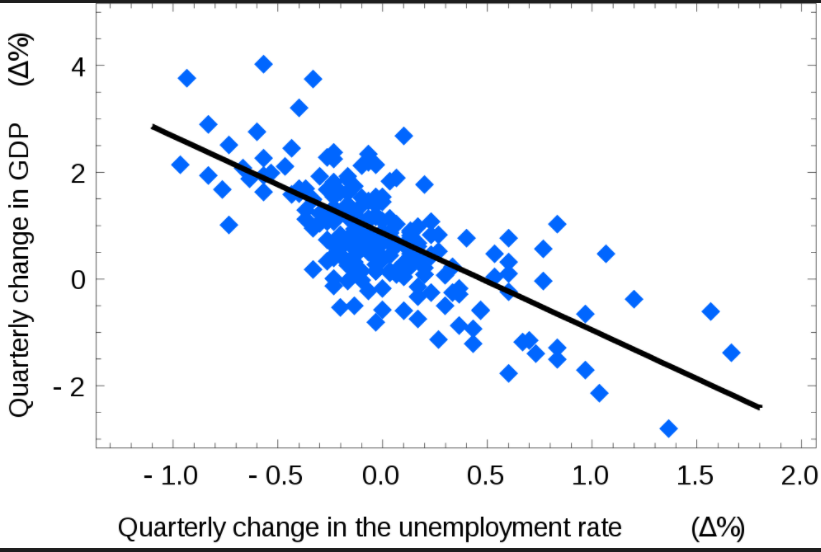

Ponieważ linia regresji nie omija zbytnio żadnego z punktów, $R^2$ regresji jest stosunkowo wysoka.

Obliczenie $R^2$ jest stosunkowo proste:
$$
R^2 \equiv \frac{\text{MSE}_{średnia} - \text{MSE}_{model}}{\text{MSE}_{średnia}}
$$

Kontynuując korzystanie z kwadratowej zmiennej `model2`, którą wprowadziliśmy wcześniej, obliczymy wartość $R^2$.

In [38]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Extent   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     69.27
Date:                Mon, 29 Jan 2024   Prob (F-statistic):           3.65e-12
Time:                        19:40:45   Log-Likelihood:                -20.011
No. Observations:                  34   AIC:                             46.02
Df Residuals:                      31   BIC:                             50.60
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0851      0.222     31.959      0.000       6.633       7.537
YearAdj        0.0417      0.031      1.340      0.190      -0.022       0.105
YearAdj2      -0.0039      0.001     -4.297      0.000      -0.006      -0.002
==============================================================================
Omnibus:                        0.913   Durbin-Watson:                   2.274
Prob(Omnibus):                  0.634   Jarque-Bera (JB):                0.902
Skew:                          -0.349   Prob(JB):                        0.637
Kurtosis:                       2.614   Cond. No.                     1.42e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.42e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [39]:
import numpy as np

model_mean = smf.ols("Extent ~ 1", data=ice_df).fit()
resid_mean, resid_model = np.mean(model_mean.resid**2), np.mean(model2.resid**2) # we can also use the .ssr attribute
(resid_mean - resid_model)/resid_mean

0.8171465357201727

Więc nasz kwadratowy model może wyjaśnić nieco ponad 81,7% wariancji. Metoda `.summary()`, która została właśnie wywołana, pokazuje również coś znanego jako „Adj R-squard”. Jest to modyfikacja $R^2$, która uwzględnia liczbę zmiennych objaśniających w naszym modelu w stosunku do liczby punktów danych. Jest to bardziej odpowiednia miara oceny modelu. Więcej informacji można znaleźć [tutaj](https://en.wikipedia.org/wiki/Coefficient_of_determination#Adjusted_R2). Wyodrębnimy skorygowane reszty za pomocą atrybutu `mse_resid`, a następnie zastosujemy tę samą formułę jak powyżej.

In [40]:
resid_mean, resid_model = model_mean.mse_resid, model2.mse_resid
(resid_mean - resid_model)/resid_mean # QED

0.8053495380247

## Korelacja

Korelacja jest miarą związku między dwiema zmiennymi. Działa to w nieco innym kontekście niż ten, który właśnie widzieliśmy, ponieważ nie mierzymy zmiennej endogennej (odpowiedzi) względem zmiennej egzogenicznej (wyjaśniającej). Raczej po prostu mierzymy jakąś formę powiązania między dwiema zmiennymi.

Jestem pewna, że już wcześniej zetknąłeś się z tym terminem i rozumiesz go intuicyjnie, ale tylko dla kompletności:
- **Dodatnia korelacja (+1)**: Gdy wzrost jednej zmiennej wskazuje na wzrost innej (np. temperatura vs sprzedaż lodów)
- **Brak korelacji (0)**: Gdy wzrost/spadek jednej zmiennej nie ma wpływu na inną (np. temperatura vs cena akcji)
- **Korelacja ujemna (-1)**: Gdy wzrost jednej zmiennej oznacza spadek innej (np. Temperatura w porównaniu ze sprzedażą sprzętu narciarskiego)

Nie będziemy zagłębiać się w szczegóły obliczania korelacji. Jest to stosunkowo proste, a [to](https://www.mathsisfun.com/data/correlation.html) i [to](https://www.youtube.com/watch?v=mG__Wpp9dns) to świetne zasoby do zrozumieć, jak działają. To, co chcę podkreślić, to dwie rzeczy:
1. Czy współczynnik korelacji jest znany jako $r$. To $r$ jest powiązane z wartością $R^2$ dla *prostej regresji liniowej*. $R^2$ to... cóż... po prostu kwadrat korelacji $r$. Aby to zweryfikować, możemy użyć metody korelacji (np. https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html).
2. Korelacja dostarcza tylko użytecznych wartości dla relacji liniowych! Jeśli twój związek jest kwadratowy, sześcienny, wykładniczy itp., to korelacja nie może tego wyjaśnić. Powinniśmy więc użyć wykresu punktowego do sprawdzenia relacji, a nie polegać wyłącznie na wartościach korelacji.


## Wielokrotna regresja liniowa

W rzeczywistości oczywiście nie będziemy pracować z tak prostymi zestawami danych, jak zestaw danych lodowych. I możemy przyznać, że na wartość jednej zmiennej (np. zmiennej docelowej) może wpływać wiele innych zmiennych. Dlatego też mylące jest badanie relacji pojedynczo, w których mogą wystąpić te złożone interakcje między zmiennymi. Dlatego powinniśmy rozważyć wiele zmiennych jednocześnie. Jak przedstawiono w rozdziale 1, jest to znane jako regresja wielowymiarowa (lub wielowymiarowa regresja liniowa). Wprowadzony powyżej wzór regresji kwadratowej był przykładem wielokrotnej regresji liniowej. Ogólny wzór wyraża się wzorem:

$$
\hat{y_i} = \beta_1x_{1,i} + \beta_2x_{2,i} + \beta_3x_{3,i} + ... + \beta_b + \epsilon_{i}
$$

Gdzie każdy termin jest zgodny z definicjami wprowadzonymi wcześniej.

Przejdziemy do innego zbioru danych - ogólnego badania społecznego w USA z 2018 roku. Dane pochodzą z https://gssdataexplorer.norc.org/. Interesuje nas modelowanie zmiennej `prestg10`, która jest oceną prestiżu zawodu respondenta - zasadniczo miarą prestiżu danej ścieżki kariery opartej na ogólnej świadomości. Tutaj wyodrębniłam zmienne poziomu wykształcenia, ale służy to wyłącznie celowi przykładu. Ogólne podejście polegałoby na zastosowaniu następujących metodologii do zbioru danych w celu określenia, które zmienne są istotne.

Jako przykład podajemy kilka ról i związane z nimi oceny prestiżu. Zwróć uwagę, że te wyniki nie są istotne ani reprezentatywne dla zestawu danych, do którego ładujemy, a raczej są one przedstawione tylko po to, aby dać ci ogólne pojęcie o tym, co oznaczają wyniki.
<table>
    <head>
        <tr>
            <th>Rola</th>
            <th>Wynik</th>
        <tr>
    </head>
    <tbody>
        <tr>
            <td>Dyrektor generalny lub główny administrator, administracja publiczna</td>
            <td>70,45</td>
        </tr>
        <tr>
            <td>Menedżer, medycyna i zdrowie</td>
            <td>69,22</td>
        </tr>
        <tr>
            <td>Architekt</td>
            <td>73,15</td>
        </tr>
        <tr>
            <td>Inżynier lotniczy</td>
            <td>69,22</td>
        </tr>
        <tr>
            <td>Inżynier budownictwa</td>
            <td>68,81</td>
        </tr>
        <tr>
            <td>Inżynier (nie sklasyfikowany gdzie indziej)</td>
            <td>70,69</td>
        </tr>
        <tr>
            <td>Analityk systemów komputerowych lub naukowiec</td>
            <td>73,70</td>
        </tr>
        <tr>
            <td>Fizyk lub astronom</td>
            <td>73,48</td>
        </tr>
        <tr>
            <td>Chemik</td>
            <td>73,33</td>
        </tr>
        <tr>
            <td>Geolog/geodesta</td>
            <td>69,75</td>
        </tr>
        <tr>
            <td>Lekarz</td>
            <td>86.05</td>
        </tr>
        <tr>
            <td>Profesor</td>
            <td>71,79</td>
        </tr>
        <tr>
            <td>Nauczyciel</td>
            <td>73,51</td>
        </tr>
    </tbody>
</table>

Zestaw danych wymaga niewielkiej ilości czyszczenia i ekstrakcji danych. Zrobiłem to dla nas, aby zaoszczędzić czas.

In [41]:
import pandas as pd
import numpy as np


In [42]:
gss_df = pd.read_csv("GSS.csv")
gss_df

FileNotFoundError: [Errno 2] No such file or directory: 'GSS.csv'

In [44]:
# This is a quick, dirty hack just to allow us to work with some clean data. Don't do stuff like this in practise.
cols = ["age", "educ", "paeduc", "maeduc", "speduc", "degree", "sex", "prestg10"]
gss_df.columns = cols

# For now we will introduce these categorical variables as equally spaced numerics. We'll look explicitly at categorical data later down the notebook
degree_codes = {"Lt high school": 0, "High school": 1, "Junior college": 2, "Bachelor": 3, "Graduate": 4}
sex_codes = {"Female": 0, "Male": 1}

to_replace = {"degree": degree_codes, "sex": sex_codes}
gss_df = gss_df.replace(to_replace)

gss_df = gss_df.replace(["Not applicable", "Don't know", "No answer", "89 or older"], pd.NA)
for col in cols:
    gss_df[col] = pd.to_numeric(gss_df[col], errors="coerce")

gss_df[gss_df["prestg10"] == 0] = np.nan
gss_df[gss_df["age"] >= 98] = np.nan
gss_df[gss_df["educ"] >= 97] = np.nan
gss_df[gss_df["paeduc"] >= 97] = np.nan
gss_df[gss_df["maeduc"] >= 97] = np.nan
gss_df[gss_df["speduc"] >= 97] = np.nan
gss_df = gss_df.dropna()
gss_df

NameError: name 'gss_df' is not defined

Do tej ramki danych dopasujemy model liniowy

In [ ]:
## Fit a linear model for all variables in the gss_df and return the summary
gss_model0 = smf.ols("prestg10 ~ age + educ + paeduc + maeduc + speduc + sex + degree", data=gss_df).fit()
print(gss_model0.summary())

                            OLS Regression Results                            
Dep. Variable:               prestg10   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     42.29
Date:                Sun, 08 May 2022   Prob (F-statistic):           7.69e-50
Time:                        21:31:34   Log-Likelihood:                -2730.6
No. Observations:                 711   AIC:                             5477.
Df Residuals:                     703   BIC:                             5514.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     22.3408      3.620      6.172      0.0

Teraz, gdy mamy wiele zmiennych objaśniających, musimy wykazać się pewną ostrożnością podczas interpretacji współczynników. Współczynnik „eduk” wynosi -0,1432. Wartość ta określa, że jeśli wszystkie inne zmienne egzogeniczne są utrzymywane na stałym poziomie, to wzrost o jedną jednostkę poziomu wykształcenia respondenta wiąże się ze spadkiem o 0,143 wyniku prestiżu respondenta. Ta logika obowiązuje we wszystkich zmiennych objaśniających.

Gdybyśmy dopasowali model tylko do edukacji, zobaczylibyśmy, że ten współczynnik jest inny:

In [ ]:
print(smf.ols("prestg10 ~ educ", data=gss_df).fit().summary())
# smf.ols("prestg10 ~ degree", data=gss_df).fit().summary()

                            OLS Regression Results                            
Dep. Variable:               prestg10   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     185.4
Date:                Sun, 08 May 2022   Prob (F-statistic):           1.12e-37
Time:                        21:31:48   Log-Likelihood:                -2773.0
No. Observations:                 711   AIC:                             5550.
Df Residuals:                     709   BIC:                             5559.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     17.9189      2.288      7.833      0.0

Tutaj obserwujemy, że sama „edukacja” odpowiada za 20,6% wariancji i ma znacznie wyższy współczynnik niż wcześniej. Wynik jest inny, ponieważ wykształcenie respondentów jest pozytywnie skorelowane z innymi zmiennymi w ramce danych (pokazane poniżej). Mówiąc prościej, jeśli poziom wykształcenia rodziców wynosi 👆, to prawdopodobnie wykształcenie dziecka również wynosi 👆.

Zatem wiedza, że ​​poziom wykształcenia respondenta jest wysoki, będzie wskazywać, że inne poziomy wykształcenia są prawdopodobnie również powyżej średniej. Równanie regresji odzwierciedla pozytywny wkład innych osób w życiu respondenta. Tak więc wartość parametru tego modelu (2.10) obejmuje *bezpośredni* wpływ poziomu wykształcenia respondenta oraz *pośredni* wpływ poziomu wykształcenia matek, ojców i małżonków, płeć i wiek respondenta oraz, co najważniejsze, stopień respondenta.

Konsekwencją tego jest model mierzący efekty pośrednie, jeśli pominiemy efekty bezpośrednie. Dlatego dodanie lub usunięcie zmiennych z równania regresji może (i zwykle będzie) zmienić wartości oszacowań parametrów i ich znaczenie

In [ ]:
gss_df.corr()

,age,educ,paeduc,maeduc,speduc,degree,sex,prestg10
age,1.000000,-0.015171,-0.165227,-0.173607,0.014271,-0.034259,0.114786,0.059539
educ,-0.015171,1.000000,0.484509,0.423026,0.586067,0.861650,0.019650,0.455316
paeduc,-0.165227,0.484509,1.000000,0.688398,0.441658,0.450612,-0.009904,0.329904
maeduc,-0.173607,0.423026,0.688398,1.000000,0.418818,0.385597,0.023026,0.317850
speduc,0.014271,0.586067,0.441658,0.418818,1.000000,0.533071,0.059110,0.386766
degree,-0.034259,0.861650,0.450612,0.385597,0.533071,1.000000,-0.013018,0.499075
sex,0.114786,0.019650,-0.009904,0.023026,0.059110,-0.013018,1.000000,0.095970
prestg10,0.059539,0.455316,0.329904,0.317850,0.386766,0.499075,0.095970,1.000000


In [ ]:
import plotly.express as px

In [ ]:
px.imshow(gss_df.corr(), color_continuous_scale='Agsunset', title="Correlation heatmap of GSS dataframe")

Ciekawe rzeczy z tej tabeli:
1. Ciekawe, dlaczego wiek i wykształcenie są ze sobą ujemnie skorelowane... narysujmy i zobaczmy, czy możemy coś dostrzec
2. wykształcenie i stopień mają wysoką korelację.

In [ ]:
px.scatter(gss_df, "age", "educ")

Kontynuując... Ustaliliśmy więc, że włączenie lub wykluczenie warunków może się zmienić, może zmienić wartości współczynników i odpowiadające im wartości p. Oznacza to, że gdy próbujemy zidentyfikować istotne zmienne, model powinien zostać ponownie dopasowany po usunięciu najmniej znaczącej zmiennej. W przypadku dużych ramek/zestawów danych może to okazać się trudnym problemem. Czy jako hakerzy możesz wymyślić sposób, w jaki moglibyśmy zautomatyzować ten proces?

Tak więc, aby wyjaśnić, na każdym etapie naszego procesu budowania modelu:
1. Spójrz na wszystkie nieistotne zmienne
2. Usuń najmniej znaczącą zmienną
3. Zamontuj model!
4. Powtarzaj ten proces, aż wszystkie zmienne będą znaczące

Jaka jest najmniej znacząca zmienna w naszym `gss_model0`?

In [ ]:
## Remove the least significant variable from the model
gss_model1 = smf.ols("prestg10 ~ age + paeduc + maeduc + speduc + sex + degree", data=gss_df).fit()
print(gss_model1.summary())

                            OLS Regression Results                            
Dep. Variable:               prestg10   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     49.36
Date:                Sun, 08 May 2022   Prob (F-statistic):           1.17e-50
Time:                        21:34:58   Log-Likelihood:                -2730.7
No. Observations:                 711   AIC:                             5475.
Df Residuals:                     704   BIC:                             5507.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     21.2283      2.734      7.764      0.0

In [ ]:
## Remove the least significant variable from the model
gss_model2 = smf.ols("prestg10 ~ age + maeduc + speduc + sex + degree", data=gss_df).fit()
print(gss_model2.summary())

                            OLS Regression Results                            
Dep. Variable:               prestg10   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     58.88
Date:                Sun, 08 May 2022   Prob (F-statistic):           3.04e-51
Time:                        21:38:51   Log-Likelihood:                -2731.5
No. Observations:                 711   AIC:                             5475.
Df Residuals:                     705   BIC:                             5502.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     21.7111      2.707      8.021      0.0

Prestiż pracy w USA wzrasta zatem wraz z wiekiem, wykształceniem matek, wykształceniem małżonków, płci i najwyższym uzyskanym stopniem.

Tutaj pracowaliśmy z małym zbiorem danych i musieliśmy przejść tylko przez 2 iteracje, aby zidentyfikować wszystkie nasze istotne zmienne. To podejście, które zastosowaliśmy, w którym dopasowujemy wszystkie zmienne, a następnie iteracyjnie usuwamy nieistotne, jest znane jako **eliminacja wsteczna**. Z drugiej strony istnieje również metoda znana jako **selekcja postępująca**. Tutaj zaczęlibyśmy od najprostszego możliwego modelu (tj. średniej), a następnie zidentyfikowalibyśmy, która JEDNĄ zmienną ma największe znaczenie dla naszego modelu. Ta zmienna jest następnie dodawana do nowego modelu, a proces jest powtarzany. Generalnie preferowana jest selekcja wsteczna, mimo że praca z dużą liczbą zmiennych jest trudniejsza.

Jednak, jak wspomniałem wcześniej... jesteśmy hakerami... możemy stworzyć funkcję, która pobiera ramkę danych i zmienną odpowiedzi, iteracyjnie usuwa zmienną o najniższym znaczeniu, zwracając nam model zawierający tylko zmienne istotne. Zakodujmy to (ponieważ prawdopodobnie będzie to świetna okazja do zaoszczędzenia czasu podczas pracy z większymi zbiorami danych)

In [ ]:
def prune_models(dataframe, response_col_name):
    
    # We're going to need to define the f irst part of our formula string. 
    # We know it'll start with the response_col_name followed with a "~"
    ## Define the first part of our formula string (~ 1 line)
    init_formula_string = response_col_name + " ~ "
    
    # Next, we're going to initially start with ALL the columns in our dataframe. 
    # We can use the string <join> method to create this string
    # Remember to <remove> the response_col_name from our columns list!
    ## Create the second part of the formula string (~ 3 lines)
    ### Assign cols_no_response to the list of the dataframe columns
    cols_no_response = dataframe.columns.tolist()
    ### <Remove> the response column name
    cols_no_response.remove(response_col_name)
    ### <Join> the string (using ' + ') as the join seperator
    rest_of_formula_string = " + ".join(cols_no_response)
    
    ## Concat the two strings together (in a new variable) to obtain our full formula string (~ 1 line)
    formula_string = init_formula_string + rest_of_formula_string

    ## Fit the initial model variation (i.e. all features)(~1 line)
    model_init = smf.ols(formula_string, data=dataframe).fit()
    
    # We know we only care about the p-values from the summary table - use the pvalues attribute to extract this out
    ## Assign a p-values variable (~ 1 line)
    pvalues = model_init.pvalues
    
    ## Find the variable with the highest p-value (hint: idxmax) (~1 line)
    max_p = pvalues.idxmax()
    
    # We know when can stop our model building process when the highest p-value from our model is under an alpha value
    ## Define our alpha threshhold at 0.05 (~ 1 line)
    alpha = 0.05
    
    # With our alpha defined, we need to perform the following steps:
    # <While> loop over our p-values with the condition that the max value is above our alpha threshold (~ 1 line)
    # Identify the variable with the maximum p-value (~ 1 line)
    # Drop this variable from our cols_no_response list (~ 1 line)
    # Create a new formula string (~ 2 lines)
    # Fit the new model (~ 1 line)
    # Re-declare our p-values variable (~ 1 line)
    # <Drop> the Intercept attribute (~ 1 line)
    # Once our while loop breaks, let's return the model (~ 1 line)
    ## Implement the above instructions (~ 9 lines)
    
    while pvalues.max() > alpha:
        max_p = pvalues.idxmax()
        cols_no_response.remove(max_p)
    
        rest_of_formula_string = " + ".join(cols_no_response)
        formula_string = init_formula_string + rest_of_formula_string
        
        model = smf.ols(formula_string, data=dataframe).fit()
        pvalues = model.pvalues
        pvalues = pvalues.drop("Intercept")
        
    return model
    
fitted_model = prune_models(gss_df, "prestg10")
## Print the model summary
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               prestg10   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     58.88
Date:                Sun, 08 May 2022   Prob (F-statistic):           3.04e-51
Time:                        21:48:51   Log-Likelihood:                -2731.5
No. Observations:                 711   AIC:                             5475.
Df Residuals:                     705   BIC:                             5502.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     21.7111      2.707      8.021      0.000      16.397      27.025
age            0.0758      0.029      2.603      0.009       0.019       0.133
maeduc         0.4705      0.131      3.604      0.000       0.214       0.727
speduc         0.5308      0.175      3.025      0.003       0.186       0.875
degree         4.1571      0.409     10.168      0.000       3.354       4.960
sex            2.1858      0.859      2.546      0.011       0.500       3.872
==============================================================================
Omnibus:                        2.076   Durbin-Watson:                   2.068
Prob(Omnibus):                  0.354   Jarque-Bera (JB):                1.898
Skew:                          -0.037   Prob(JB):                        0.387
Kurtosis:                       2.758   Cond. No.                         357.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Taki sam model, jaki ustaliliśmy wcześniej? . Jako dodatek, rozszerzmy wszystkie nasze dane poza naszą zmienną odpowiedzi o wyrażenia kwadratowe i sześcienne, a następnie przeprowadźmy je przez powyższą funkcję.

In [ ]:
augmented_gss_df = gss_df

## Drop the response_variable from the augmented dataframe (we'll add it back in later)
augmented_gss_df = augmented_gss_df.drop("prestg10", axis=1)

## For every column in our dataframe, let's create new columns, named <COLUMNNAME>2 or <COLUMNNAME>3 which store the columns squared and cubed terms
## We'll ignore the 'categorical' sex and degree column
for col in augmented_gss_df.columns:
    if col == "sex" or col == "degree":
        continue
    augmented_gss_df[col+str(2)] = augmented_gss_df[col] ** 2
    augmented_gss_df[col+str(3)] = augmented_gss_df[col] ** 3
    
## Add prestg10 from gss_df back into augmented_gss_df
augmented_gss_df["prestg10"] = gss_df["prestg10"]

## Run our above function!
fitted_model_poly = prune_models(augmented_gss_df, "prestg10")
## Print the model summary
fitted_model_poly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               prestg10   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     37.83
Date:                Sun, 08 May 2022   Prob (F-statistic):           4.67e-50
Time:                        21:48:58   Log-Likelihood:                -2728.1
No. Observations:                 711   AIC:                             5474.
Df Residuals:                     702   BIC:                             5515.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1408     13.516      0.010      0.992     -26.395      26.677
age            1.6501      0.822      2.007      0.045       0.036       3.264
degree         4.1098      0.413      9.944      0.000       3.298       4.921
sex            2.0927      0.860      2.433      0.015       0.404       3.782
age2          -0.0315      0.016     -1.965      0.050      -0.063   -3.34e-05
age3           0.0002      0.000      1.985      0.048    2.14e-06       0.000
maeduc2        0.0926      0.029      3.205      0.001       0.036       0.149
maeduc3       -0.0037      0.001     -2.522      0.012      -0.007      -0.001
speduc2        0.0183      0.006      2.926      0.004       0.006       0.031
==============================================================================
Omnibus:                        2.308   Durbin-Watson:                   2.064
Prob(Omnibus):                  0.315   Jarque-Bera (JB):                2.094
Skew:                          -0.048   Prob(JB):                        0.351
Kurtosis:                       2.752   Cond. No.                     6.82e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.82e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Niesamowite! Teraz programowo zrobiliśmy dwie rzeczy, które mogą nam zaoszczędzić mnóstwo czasu podczas pracy z większymi zbiorami danych:
1. Automatyczne określanie najlepiej dopasowanego modelu przy użyciu metody selekcji wstecznej
2. Rozszerzanie naszego zbioru danych o wyrażenia wielomianowe

Ale który model jest lepszy? Cóż, możemy spojrzeć na $R^2$, aby nam to powiedzieć. Nasz pierwszy model ma skorygowany $R^2$ o 0,290, podczas gdy rozszerzony ma skorygowany o 0,293. Czy to oznacza, że ​​nasz model rozszerzony jest lepszy? Ja bym się nie spierał – mimo że metryka jest wyższa. Zazwyczaj preferowane są prostsze modele, a dalsze badanie tego nowego modelu może zająć znacznie więcej czasu, niż jest to warte dla dodatkowej 0,3% wariancji.

## Zmienne kategorialne

Do tej pory „zhakowaliśmy” dane kategorialne w modelu, kodując je jako typ numeryczny/ciągły. Dzieje się tak, ponieważ interpretacja dopasowanych wyników zmiennej kategorialnej jest nieco bardziej skomplikowana.

W naszych danych mamy dwie zmienne kategoryczne: „płeć” i „stopień” (nie żeby miało to znaczenie w naszej interpretacji, ale zauważ, że płeć jest nominalna, a stopień jest porządkowa). Mamy dwie strategie, dzięki którym `statsmodel` wie, że mamy do czynienia z danymi kategorycznymi. Pierwszym z nich jest użycie wspomnianych kolumn wraz z metodą [`.get_dummies()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html). Zgodnie z tą metodologią dla każdej zmiennej otrzymalibyśmy X dodatkowych kolumn w naszej ramce danych, gdzie X to liczba odrębnych elementów, które kategoria może przyjąć. Jak widzieliśmy w poprzednim notatniku, nowe kolumny byłyby binarne, z wartością 0 lub 1 w zależności od tego, który z elementów jest odpowiedni dla odpowiedniego wiersza.

Drugim, prostszym i bardziej eleganckim rozwiązaniem jest użycie `C(<NAZWAKOLUMNY>)` w naszym ciągu formuły dla kolumny, którą chcemy zakodować jako kategoryczną. Zaczniemy od zbudowania modelu tylko na dwóch wspomnianych powyżej kategoriach, abyśmy mogli zrozumieć, jak interpretować wyniki.

Uwaga Jeśli twoja zmienna jest zakodowana jako ciąg, `statsmodels` automatycznie zinterpretuje ją jako zmienną kategorialną podczas dopasowywania modelu. Jeśli mamy zmienną kategorialną zakodowaną jako numeryczny typ danych (tak jak robimy to z płcią i stopniem), to użycie `C` jest konieczne

In [ ]:
gss_cat = smf.ols("prestg10 ~ C(sex) + C(degree)", gss_df).fit()
gss_cat.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               prestg10   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     49.51
Date:                Sun, 08 May 2022   Prob (F-statistic):           5.74e-44
Time:                        21:51:58   Log-Likelihood:                -2748.6
No. Observations:                 711   AIC:                             5509.
Df Residuals:                     705   BIC:                             5537.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           35.8056      1.825     19.619      0.000      32.222      39.389
C(sex)[T.1.0]        2.7890      0.877      3.182      0.002       1.068       4.510
C(degree)[T.1.0]     5.5069      1.897      2.904      0.004       1.783       9.231
C(degree)[T.2.0]    10.9385      2.272      4.815      0.000       6.479      15.398
C(degree)[T.3.0]    16.5342      1.956      8.451      0.000      12.693      20.375
C(degree)[T.4.0]    21.1986      2.064     10.269      0.000      17.146      25.251
==============================================================================
Omnibus:                        0.816   Durbin-Watson:                   2.059
Prob(Omnibus):                  0.665   Jarque-Bera (JB):                0.907
Skew:                          -0.052   Prob(JB):                        0.635
Kurtosis:                       2.860   Cond. No.                         11.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
print(to_replace)

{'degree': {'Lt high school': 0, 'High school': 1, 'Junior college': 2, 'Bachelor': 3, 'Graduate': 4}, 'sex': {'Female': 0, 'Male': 1}}


Tak więc dla płci mamy 2 kategorie: „0” i „1”. Dla stopnia jest 5. W podsumowaniu modelu jesteśmy świadkami wpływu, jaki różne kategorie mają na model, ale nie widzimy kategorii 0 ani dla płci, ani dla stopnia. Ta pominięta kategoria jest znana jako kategoria **referencyjna** i jest zakodowana w polu Intercept.

Oznacza to, że dla respondentki (kategoria płci 0), która ma wykształcenie niższe niż średnie (kategoria stopnia 0), równanie to po prostu: $\hat{\text{prestg10}} = \hat{y} = 35,8$. <br>
Dla odpowiedzi kobiety z wykształceniem licencjackim równanie to: $\hat{y} = 35,8 + 16,5 $. <br>
A dla respondenta z wykształceniem licencjackim równanie to $\hat{y} = 35,8 + 2,79 + 16,5 $.

Matematycznie byłoby to napisane jako:
$$
\hat{y_i} = \beta_b + \beta^{\text{płeć}}_j + \beta^{\text{stopień}}_k
$$

Gdzie $j$ i $k$ indeksują liczbę unikalnych kategorii dla odpowiedniej zmiennej, nie biorąc pod uwagę kategorii odniesienia. Czyli $j = 1, k = 1...4$.

Porównanie efektów między kategoriami, przy jednoczesnym utrzymaniu stałych pozostałych zmiennych, jest proste, gdy jedna z kategorii jest kategorią pominiętą/odniesienia. Na przykład mężczyźni wpływają na wynik prestg o 2,79 punktu, a osoby z wykształceniem wyższym uzyskują wyniki prestg o około 21,2 wyższe niż osoby z kategorii 0.

Aby porównać dwie kategorie razem, po prostu bierzemy różnicę między oszacowanymi parametrami. Na przykład osoby z tytułem magistra mają wynik o 4,67 wyższy niż osoby z tytułem licencjata (21,1986 - 16,5342).

A co z interpretacją wartości p? Cóż, to nie jest to samo, co zrobiliśmy wcześniej, ponieważ w przypadku zmiennej kategorialnej wynik `.summary()` daje nam wartości p oparte na testach t, ​​które porównują określony poziom z wartością odniesienia poziom (np. licencjat vs. liceum). **Nie powinniśmy** używać tych wartości p, aby wybrać model do zastosowania – raczej chcemy rozważyć udział czynnika jako całości. Robimy to za pomocą metody znanej jako **zmiana sumy kwadratów**.

Przypomnijmy, że najprostszy model, jaki możemy dopasować, to taki, który używa stałej do przewidywania zmiennej. Używamy tego do określenia naszej początkowej sumy kwadratów. Suma kwadratów dla modelu, który pasuje do średniej, jest znana jako **całkowita suma kwadratów** (matematycznie $\sum_i^n (y_i - \bar{y})^2$).

In [ ]:
gss_tssr = smf.ols("prestg10 ~ 1", gss_df).fit().ssr
gss_tssr

128190.83544303797

Teraz dodamy do tego modelu zmienną kategorialną i zaobserwujemy, jak zmieniła się suma kwadratów:

In [ ]:
128190.83544303797 - 127010.15553618138

1180.6799068565888

In [ ]:
# Perhaps gender here is a more appropiate name than sex...
gss_gender_model = smf.ols("prestg10 ~ C(sex)", gss_df).fit()
gss_gender_model.ssr

127010.15553618138

Widzimy, że suma kwadratów została zmniejszona do 127.010. Oznacza to, że uwzględnienie zmiennej płci zmniejszyło naszą resztkową sumę kwadratów o ~1181. Zobaczmy, jak bardzo włączenie stopnia wpływa na naszą resztkową sumę kwadratów.

In [ ]:
gss_gender_degree_model = smf.ols("prestg10 ~ C(sex) + C(degree)", gss_df).fit()
gss_gender_degree_model.ssr

94878.66758256512

Uwzględnienie 5 poziomów stopni w naszym modelu dodatkowo zmniejsza sumę kwadratów o ~32131. Ten wynik pokazuje, w jaki sposób można podzielić całkowitą sumę kwadratów na zmienność przypisywaną różnicy płci, stopnia i pozostałej zmienności resztowej. Możemy wyświetlić te informacje za pomocą tabeli **ANOVA** (wszystkie te tabele ANOVA są jednokierunkową ANOVA, ponieważ pracujemy z jedną zmienną odpowiedzi).

In [ ]:
import statsmodels.api as sm
sm.stats.anova_lm(gss_gender_degree_model, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
C(sex),1.0,1180.679907,1180.679907,8.773093,3.159871e-03
C(degree),4.0,32131.487954,8032.871988,59.688599,2.013562e-43
Residual,705.0,94878.667583,134.579670,NaN,NaN


To, co zostało przedstawione powyżej, to wyniki analizy wariancji **Typ 1** ANOVA. ANOVA typu 1 daje różne wyniki w zależności od kolejności wprowadzania danych do modelu:

In [ ]:
gss_degree_gender_model = smf.ols("prestg10 ~ C(degree) + C(sex)", gss_df).fit()
sm.stats.anova_lm(gss_degree_gender_model, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
C(degree),4.0,31949.681098,7987.420275,59.350868,3.322286e-43
C(sex),1.0,1362.486762,1362.486762,10.124016,1.527707e-03
Residual,705.0,94878.667583,134.579670,NaN,NaN


**Typ 2** ANOVA przedstawia natomiast wpływ każdego warunku przy wszystkich pozostałych terminach zachowanych w modelu. Ten wariant metody jest zalecany.

In [ ]:
sm.stats.anova_lm(gss_gender_degree_model, typ=2)
# sm.stats.anova_lm(gss_degree_gender_model, typ=2)

,sum_sq,df,F,PR(>F)
C(sex),1362.486762,1.0,10.124016,1.527707e-03
C(degree),32131.487954,4.0,59.688599,2.013562e-43
Residual,94878.667583,705.0,NaN,NaN


Tabela ANOVA zwraca nam również bardziej formalne wartości p — których, jak widzieliśmy, powinniśmy użyć do podjęcia decyzji, czy zachować zmienną, czy nie. Wartość p w tabeli ANOVA jest obliczana przy użyciu czegoś, co nazywa się [testem F](https://en.wikipedia.org/wiki/F-test) – co jest po prostu stosunkiem dwóch wariancji (uwzględniających stopnie wolność). Nie będziemy tutaj zagłębiać się w szczegóły, ponieważ ważne jest, aby wiedzieć, czy chcemy zachować, czy porzucić zmienną.

In [ ]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               prestg10   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     58.88
Date:                Sun, 08 May 2022   Prob (F-statistic):           3.04e-51
Time:                        21:52:21   Log-Likelihood:                -2731.5
No. Observations:                 711   AIC:                             5475.
Df Residuals:                     705   BIC:                             5502.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     21.7111      2.707      8.021      0.000      16.397      27.025
age            0.0758      0.029      2.603      0.009       0.019       0.133
maeduc         0.4705      0.131      3.604      0.000       0.214       0.727
speduc         0.5308      0.175      3.025      0.003       0.186       0.875
degree         4.1571      0.409     10.168      0.000       3.354       4.960
sex            2.1858      0.859      2.546      0.011       0.500       3.872
==============================================================================
Omnibus:                        2.076   Durbin-Watson:                   2.068
Prob(Omnibus):                  0.354   Jarque-Bera (JB):                1.898
Skew:                          -0.037   Prob(JB):                        0.387
Kurtosis:                       2.758   Cond. No.                         357.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
fitted_model = smf.ols("prestg10 ~ age + maeduc + speduc + C(degree) + C(sex)", gss_df).fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               prestg10   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     37.09
Date:                Sun, 08 May 2022   Prob (F-statistic):           3.54e-49
Time:                        21:52:26   Log-Likelihood:                -2730.2
No. Observations:                 711   AIC:                             5478.
Df Residuals:                     702   BIC:                             5520.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           22.9499      2.891      7.939      0.000      17.274      28.626
C(degree)[T.1.0]     1.1947      1.997      0.598      0.550      -2.727       5.116
C(degree)[T.2.0]     6.4227      2.355      2.728      0.007       1.799      11.046
C(degree)[T.3.0]    10.0504      2.244      4.480      0.000       5.646      14.455
C(degree)[T.4.0]    13.9410      2.398      5.815      0.000       9.234      18.648
C(sex)[T.1.0]        2.1984      0.864      2.545      0.011       0.502       3.895
age                  0.0785      0.029      2.689      0.007       0.021       0.136
maeduc               0.4997      0.133      3.771      0.000       0.240       0.760
speduc               0.5837      0.180      3.250      0.001       0.231       0.936
==============================================================================
Omnibus:                        1.836   Durbin-Watson:                   2.077
Prob(Omnibus):                  0.399   Jarque-Bera (JB):                1.701
Skew:                          -0.027   Prob(JB):                        0.427
Kurtosis:                       2.766   Cond. No.                         553.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
sm.stats.anova_lm(fitted_model, typ=2)

,sum_sq,df,F,PR(>F)
C(degree),13584.317403,4.0,26.459044,1.844207e-20
C(sex),831.019222,1.0,6.474517,1.115625e-02
age,928.321730,1.0,7.232607,7.329123e-03
maeduc,1824.943719,1.0,14.218239,1.764907e-04
speduc,1355.805473,1.0,10.563156,1.208688e-03
Residual,90103.318741,702.0,NaN,NaN


Świetny! Wszystkie nasze zmienne (przy uwzględnieniu prawidłowo określonych wariantów kategorii) mają duże znaczenie dla naszego modelu. Następnie rozszerzymy nasz model o terminy zwane **interakcjami**.

## Interakcje

Interakcja ma miejsce, gdy zmienna objaśniająca ma nieaddytywny wpływ na wynik modelu w zależności od obecności innej zmiennej objaśniającej. W tym przykładzie, biorąc pod uwagę tylko model kategoryczny, wpływ stopnia może być inny dla mężczyzn i kobiet. Gdybyśmy chcieli przedstawić to matematycznie, potrzebowalibyśmy dodatkowego parametru:

$$
\hat{y}_i = \beta_b + \beta^{płeć}_j + \beta^{stopień}_k + \beta^{płeć \cdot stopień}_{jk}
$$

Terminy w powyższym równaniu są zgodne z wprowadzonymi wcześniej. Wartości $\beta^{sex \cdot degree}_{jk}$ przyjmujemy jako zero, gdy kategorią odniesienia jest $j$ lub $k$. Zatem $j=1, k=3$ oznacza, że ​​mamy respondenta płci męskiej, który uzyskał tytuł licencjata. Wcześniej modelowaliśmy każdą ze zmiennych odpowiednio za pomocą $\beta^{sex}_j, \beta^{degree}_k$. Teraz, obok tych dwóch parametrów, mamy dodatkowy parametr, który modeluje, jak zmienia się ocena prestiżu w oparciu o wspólną interakcję poziomu wykształcenia i płci respondenta.

Więcej informacji na temat terminów interakcji można znaleźć [tutaj](http://www.medicine.mcgill.ca/epidemiology/Joseph/courses/EPIB-621/interaction.pdf) i [tutaj](https://www.youtube.com/watch?v=HSHcIHMxhbE).

Możemy określić warunki interakcji w naszym modelu za pomocą operatora dwukropka (:), który jawnie dodaje interakcję między dwiema zmiennymi (np. `C(sex):C(degree)`). Alternatywnie możemy użyć operatora gwiazdki (\*), który dodaje sumę tych dwóch terminów i interakcję (np. `C(sex)*C(degree)` zamienia się w `C(sex) + C(sex) + C(sex):C(degree)`.

In [ ]:
interaction_model = smf.ols("prestg10 ~ C(sex)*C(degree)", gss_df).fit()
interaction_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               prestg10   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     29.85
Date:                Sun, 08 May 2022   Prob (F-statistic):           3.32e-44
Time:                        21:52:28   Log-Likelihood:                -2740.2
No. Observations:                 711   AIC:                             5500.
Df Residuals:                     701   BIC:                             5546.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         30.7619      2.509     12.261      0.000      25.836      35.688
C(sex)[T.1.0]                     12.6472      3.508      3.606      0.000       5.760      19.534
C(degree)[T.1.0]                   9.8906      2.689      3.678      0.000       4.610      15.171
C(degree)[T.2.0]                  18.3517      3.050      6.018      0.000      12.364      24.339
C(degree)[T.3.0]                  21.5500      2.740      7.865      0.000      16.170      26.930
C(degree)[T.4.0]                  28.0199      2.949      9.500      0.000      22.229      33.811
C(sex)[T.1.0]:C(degree)[T.1.0]    -8.5650      3.760     -2.278      0.023     -15.948      -1.182
C(sex)[T.1.0]:C(degree)[T.2.0]   -16.7608      4.589     -3.653      0.000     -25.770      -7.752
C(sex)[T.1.0]:C(degree)[T.3.0]    -9.7944      3.882     -2.523      0.012     -17.417      -2.172
C(sex)[T.1.0]:C(degree)[T.4.0]   -13.1634      4.096     -3.214      0.001     -21.204      -5.122
==============================================================================
Omnibus:                        1.067   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.587   Jarque-Bera (JB):                1.157
Skew:                          -0.077   Prob(JB):                        0.561
Kurtosis:                       2.875   Cond. No.                         27.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
gss_df["fitted"] = fitted_model.fittedvalues
gss_df["degree"] = gss_df["degree"].astype("category")
gss_df["sex"] = gss_df["sex"].astype("category")
px.scatter(gss_df, "degree", "fitted", color="sex", title="Degree level vs predicted values. Coloured by sex")

Podsumowanie można interpretować w następujący sposób: wpływ zmiennej płeć na prestg10 różni się w zależności od kategorii wykształcenia, które uzyskał respondent.

Na przykład, biorąc pod uwagę poziom 0 (mniejszy niż wykształcenie średnie), mężczyźni (poziom płci 1) mają 12,6 wzrost prestiżu w porównaniu z dziewczętami. Ale jeśli mężczyzna ma wykształcenie na poziomie licencjata (stopień 3), mają one (12,6 + -9,79 = 2,85) zmianę w wyniku prestiżu w porównaniu z kobietami.

Można to również interpretować w odwrotny sposób – to znaczy, że wpływ zmiennej stopnia na wynik prestiżu różni się w zależności od kategorii płci respondenta.

Możemy użyć ANOVA, aby określić, czy cały czynnik jest istotny, czy nie:

In [ ]:
sm.stats.anova_lm(interaction_model, typ=2)

,sum_sq,df,F,PR(>F)
C(sex),1362.486762,1.0,10.306372,1.386207e-03
C(degree),32131.487954,4.0,60.763721,4.444395e-44
C(sex):C(degree),2207.528560,4.0,4.174648,2.388478e-03
Residual,92671.139022,701.0,NaN,NaN


Świetny! Wszystkie znaczące. Więc dodanie tego terminu interakcji jest pozytywne, prawda? Aby to sprawdzić, dopasujmy model do innych zmiennych, które zidentyfikowaliśmy jako istotne i zobaczmy, czy nasze $R^2$ jest wyższe.

In [ ]:
smf.ols("prestg10 ~ age + maeduc + speduc + C(degree)*C(sex)", gss_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               prestg10   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                     26.34
Date:                Sun, 08 May 2022   Prob (F-statistic):           3.37e-49
Time:                        21:52:33   Log-Likelihood:                -2722.8
No. Observations:                 711   AIC:                             5472.
Df Residuals:                     698   BIC:                             5531.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         18.5008      3.333      5.551      0.000      11.957      25.044
C(degree)[T.1.0]                   5.8394      2.728      2.141      0.033       0.483      11.196
C(degree)[T.2.0]                  13.6679      3.097      4.414      0.000       7.588      19.748
C(degree)[T.3.0]                  15.1640      2.940      5.158      0.000       9.392      20.936
C(degree)[T.4.0]                  20.6474      3.202      6.449      0.000      14.361      26.933
C(sex)[T.1.0]                     11.8567      3.433      3.454      0.001       5.117      18.597
C(degree)[T.1.0]:C(sex)[T.1.0]    -8.7529      3.678     -2.380      0.018     -15.975      -1.531
C(degree)[T.2.0]:C(sex)[T.1.0]   -15.9038      4.491     -3.541      0.000     -24.722      -7.086
C(degree)[T.3.0]:C(sex)[T.1.0]    -9.4547      3.797     -2.490      0.013     -16.910      -1.999
C(degree)[T.4.0]:C(sex)[T.1.0]   -12.3876      4.010     -3.089      0.002     -20.260      -4.515
age                                0.0771      0.029      2.656      0.008       0.020       0.134
maeduc                             0.4955      0.132      3.766      0.000       0.237       0.754
speduc                             0.5436      0.179      3.032      0.003       0.192       0.896
==============================================================================
Omnibus:                        1.168   Durbin-Watson:                   2.066
Prob(Omnibus):                  0.558   Jarque-Bera (JB):                1.204
Skew:                          -0.042   Prob(JB):                        0.548
Kurtosis:                       2.817   Cond. No.                     1.21e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.21e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Wcześniej zidentyfikowaliśmy pewne podstawowe założenia opisujące regresję liniową. Dla przypomnienia były to:
1. **Liniowość** związku między odpowiedzią a zmiennymi objaśniającymi
2. **Niezależność statystyczna reszt**. Oznacza to, że nie ma dostrzegalnego wzorca w resztach (lub nie ma korelacji między kolejnymi błędami w przypadku danych szeregów czasowych)
3. **Homeescedasyczność**. Skomplikowane słowo, ale nie skomplikowana definicja. Zasadniczo oznacza po prostu, że reszty mają stałą/bardzo podobną wariancję
4. **Normalność** rozkładu błędów.

W całej powyższej analizie mocno skupiliśmy się na pierwszym punkcie. Tutaj zwrócimy większą uwagę na punkty 2, 3 i 4. Aby zademonstrować te punkty, przełączymy się na nowy zestaw danych o nazwie „drzewa”.

In [ ]:
trees = sm.datasets.get_rdataset("trees")
print(trees.__doc__)
trees_df = trees.data
trees_df

.. container::

   ===== ===============
   trees R Documentation
   ===== ===============

   .. rubric:: Diameter, Height and Volume for Black Cherry Trees
      :name: diameter-height-and-volume-for-black-cherry-trees

   .. rubric:: Description
      :name: description

   This data set provides measurements of the diameter, height and
   volume of timber in 31 felled black cherry trees. Note that the
   diameter (in inches) is erroneously labelled Girth in the data. It is
   measured at 4 ft 6 in above the ground.

   .. rubric:: Usage
      :name: usage

   ::

      trees

   .. rubric:: Format
      :name: format

   A data frame with 31 observations on 3 variables.

   ======== ========== =======
   ``[,1]`` ``Girth``  numeric Tree diameter (rather than girth, actually) in inches
   ``[,2]`` ``Height`` numeric Height in ft
   ``[,3]`` ``Volume`` numeric Volume of timber in cubic ft
   ======== ========== =======

   .. rubric:: Source
      :name: source

   Ryan, T. A., Joine

,Girth,Height,Volume
0,8.3,70,10.3
1,8.6,65,10.3
2,8.8,63,10.2
3,10.5,72,16.4
4,10.7,81,18.8
5,10.8,83,19.7
6,11.0,66,15.6
7,11.0,75,18.2
8,11.1,80,22.6
9,11.2,75,19.9


Zacznijmy od dopasowania normalnej regresji do tych danych. Postaramy się przewidzieć objętość na podstawie obwodu i wzrostu.

In [ ]:
# I'm tired of writing long variable names so I'm going to rename these columns
trees_df.columns = ["d", "h", "vol"]
trees_model0 = smf.ols("vol ~ d + h", trees_df).fit()
trees_model0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    vol   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     255.0
Date:                Sun, 08 May 2022   Prob (F-statistic):           1.07e-18
Time:                        21:52:37   Log-Likelihood:                -84.455
No. Observations:                  31   AIC:                             174.9
Df Residuals:                      28   BIC:                             179.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -57.9877      8.638     -6.713      0.000     -75.682     -40.293
d              4.7082      0.264     17.816      0.000       4.167       5.249
h              0.3393      0.130      2.607      0.014       0.073       0.606
==============================================================================
Omnibus:                        0.923   Durbin-Watson:                   1.266
Prob(Omnibus):                  0.630   Jarque-Bera (JB):                0.950
Skew:                           0.310   Prob(JB):                        0.622
Kurtosis:                       2.408   Cond. No.                         959.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Narysujmy `d` i `h` względem naszych reszt i sprawdźmy, czy możemy zidentyfikować jakieś wzorce.

In [ ]:
trees_df["residuals"] = trees_model0.resid
px.scatter(trees_df, "d", "residuals", title="Girth of tree vs model residuals")

In [ ]:
px.scatter(trees_df, "h", "residuals", title="Height of tree vs model residuals")

Drugi wykres, wysokość vs reszty, wygląda dość chaotycznie - to znaczy, że tak naprawdę nie ma żadnego dostrzegalnego wzoru. Pierwsza fabuła nie jest jednak tak zadowolona - wygląda na to, że są jakieś ślady krzywizny. Moglibyśmy dodać wyraz do kwadratu i sprawdzić jego znaczenie.

In [ ]:
## Assign a new column in trees_df which contains the d values, but squared
trees_df["d2"] = trees_df["d"] ** 2
## Fit a model on d, d^2 and h and return the summary
trees_model1 = smf.ols("vol ~ d + d2 + h", trees_df).fit()
trees_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    vol   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     383.2
Date:                Sun, 08 May 2022   Prob (F-statistic):           3.12e-22
Time:                        21:52:49   Log-Likelihood:                -71.760
No. Observations:                  31   AIC:                             151.5
Df Residuals:                      27   BIC:                             157.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -9.9204     10.079     -0.984      0.334     -30.601      10.760
d             -2.8851      1.310     -2.203      0.036      -5.573      -0.197
d2             0.2686      0.046      5.852      0.000       0.174       0.363
h              0.3764      0.088      4.266      0.000       0.195       0.557
==============================================================================
Omnibus:                        1.335   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.513   Jarque-Bera (JB):                0.961
Skew:                           0.087   Prob(JB):                        0.619
Kurtosis:                       2.155   Cond. No.                     4.66e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.66e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Świetny! Wygląda na to, że wyrażenie do kwadratu jest znaczące, a nasza $R^2$ również uległa poprawie. Wykreślmy jeszcze raz reszty, ale w stosunku do $d^2$.

In [ ]:
trees_df["residuals"] = trees_model1.resid
px.scatter(trees_df, "d2", "residuals", title="Squared diameter vs model residuals")

Nie ma tu łatwych do zidentyfikowania wzorów... Świetnie! Sprawdźmy teraz **homoskedastyczność**. Zasadniczo oznacza to po prostu, że sprawdzamy, czy wariancja między naszymi dopasowanymi wartościami a resztami jest stała. Jest to stosunkowo proste sprawdzenie, ponieważ wszystko, co musimy zrobić, to wykreślić dopasowane wartości względem naszych reszt. Następnie szukamy rosnącego lub malejącego rozrzutu punktów w miarę wzrostu dopasowanych wartości. Jak widać na naszej fabule poniżej, nie ma na to prawdziwych dowodów. Jeśli jednak istniało, zjawisko to znane jest jako **heteroskedastyczność**. Ogólnie rzecz biorąc, musielibyśmy poważnie naruszyć założenie homoskedastyczności, aby szukać alternatywnych rozwiązań - więcej porad, co zrobić w tej sytuacji, można znaleźć [tutaj](https://www.statisticssolutions.com/homoscedasticity/).

In [ ]:
trees_df["fitted"] = trees_model1.fittedvalues
px.scatter(trees_df, "fitted", "residuals", title="Fitted values vs model residuals")

To prowadzi nas do naszego ostatniego podstawowego założenia: **normalność reszt**. Istnieje wiele sposobów sprawdzenia, czy dane mają rozkład normalny, czy nie – dwie popularne metody to histogram i wykres Q-Q. W następnym zeszycie przyjrzymy się sprawdzaniu normalności z histogramów, ale jeśli chodzi o sprawdzanie normalności reszt, wolę wykresy Q-Q (odtąd QQ).

QQ to skrót od kwantyl-kwantyl. Wykres QQ graficznie pozwala nam sprawdzić, czy dane, które posiadamy, pochodzą z dowolnego rozkładu ciągłego (rozkład normalny oczywiście należy do tej kategorii). Zagłębianie się w to, jak to działa, jest nieco poza zakresem, ale w jednym zdaniu uporządkowane reszty z modelu są wykreślane względem zestawu typowych uporządkowanych reszt; które otrzymuje się z kwantyli rozkładu normalnego regularnie rozmieszczonej siatki wartości prawdopodobieństwa. Na pewno łyk... ale w rzeczywistości metodologia jest bardzo prosta. Jeśli chcesz zrozumieć, jak to działa nieco lepiej, jest kilka [świetnych](https://www.youtube.com/watch?v=okjYjClSjOg) [zasobów](https://www.statisticshowto.com/q-q- działki/), które zapewniają pełne wprowadzenie.

Interpretacja wykresu QQ ([używamy API](https://www.statsmodels.org/stable/generated/statsmodels.graphics.gofplots.qqplot.html)) jest łatwe! Czy punkty na wykresie leżą na linii? Jeśli tak, to mamy normalność! W przeciwnym razie może nie tak bardzo.

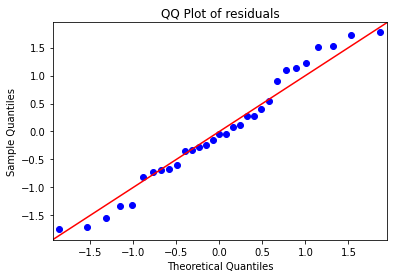

In [ ]:
from matplotlib import pyplot as plt
fig = sm.qqplot(trees_df["residuals"], fit=True, line='45')
plt.title("QQ Plot of residuals")
plt.show()

Pomimo tego, że niektóre punkty danych odbiegają od linii, normalność danych jest akceptowalna. Jeszcze więcej odchyleń niż to i zacząłbym kwestionować, czy reszty są zgodne z rozkładem normalnym.

## Transformacje

Gdyby te dane nie miały normalnego rozkładu, moglibyśmy zastosować do nich coś, co nazywamy **transformacją**. Transformacje to sposób na modyfikację naszych danych, niezależnie od tego, czy są to zmienne endogeniczne, czy egzogeniczne, w celu poprawy dopasowania i skorygowania naruszeń założeń statystycznych stojących za modelem. Przyjrzymy się tutaj dwóm strategiom transformacji, prostej transformacji $\log$ i potężniejszej transformacji Boxa-Coxa. Transformacje mogą być procesem iteracyjnym i czasami możemy mieć matematyczne uzasadnienie wyboru transformacji, podczas gdy innym razem możemy domyślnie stosować metodę prób i błędów.

Transformacje Boxa-Coxa są podane przez:
$$
y^\lambda = \begin{przypadki} \frac{y^\lambda - 1}{\lambda} & \lambda \neq 0 \\ \log(y) & \lambda = 0 \end{przypadki}
$$

Gdzie lambda zostanie znaleziona według największego prawdopodobieństwa. Interesują nas "rozsądne" wartości lambda - zazwyczaj coś, co mieści się w przedziale (-3, 3). Więc jeśli $\lambda$ okaże się równe 1, transformacja $y^1 = y$. Dlatego zmienna się nie zmienia. Podobnie:
<tabela>
    <tr>
        <td><b>Lambda</b></td>
        <td><b>Transformacja</b></td>
    </tr>
    <tr>
        <td>2</td>
        <td>Kwadrat</td>
    </tr>
    <tr>
        <td>1</td>
        <td>Brak</td>
    </tr>
    <tr>
        <td>0,5</td>
        <td>Pierwiastek kwadratowy</td>
    </tr>
    <tr>
        <td>0</td>
        <td>logarytmiczne</td>
    </tr>
    <tr>
        <td>-1</td>
        <td>Wzajemność</td>
    </tr>
    </table>
    
Najpierw przyjrzymy się transformacji Boxa-Coxa, identyfikując wartości lambda dla zmiennej obok 95% przedziału ufności.

In [ ]:
from scipy import stats

def calculate_and_plot_boxcox(variable, alpha=0.05, title_string="", plot_lower_bound=-20, plot_upper_bound=20):
    transformed_data, best_lambda, conf = stats.boxcox(variable, alpha=alpha)
    lambdas, corr_coef = stats.boxcox_normplot(variable, plot_lower_bound, plot_upper_bound)
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=lambdas, y=corr_coef))
    fig.add_shape(dict(type="line", x0=best_lambda, x1=best_lambda, y0=0, y1=1))
    fig.add_shape(dict(type="line", x0=conf[0], x1=conf[0], y0=0, y1=1, line=dict(color="Red", width=1)))
    fig.add_shape(dict(type="line", x0=conf[1], x1=conf[1], y0=0, y1=1, line=dict(color="Red", width=1)))
    fig.add_shape(dict(type="line", x0=1, x1=1, y0=0, y1=1, line=dict(color="Red", width=1, dash="dash")))
    fig.update_layout(xaxis_title="Lambda Value", yaxis_title="Correlation Coefficient", title="Box-Cox Normality Plot ({})".format(title_string))
    
    return transformed_data, best_lambda, fig

In [ ]:
transformed_h, lambda_h, fig = calculate_and_plot_boxcox(trees_df["h"], title_string="Height")
print("Obtained lambda value: ", lambda_h)
fig.show()

Obtained lambda value:  2.935266671351034


In [ ]:
transformed_d, lambda_d, fig = calculate_and_plot_boxcox(trees_df["d"], title_string="Girth")
print("Obtained lambda value: ", lambda_d)
fig.show()

Obtained lambda value:  -0.2125912067969005


In [ ]:
transformed_vol, lambda_vol, fig = calculate_and_plot_boxcox(trees_df["vol"], title_string="Volume")
print("Obtained lambda value: ", lambda_vol)
fig.show()

Obtained lambda value:  -0.07476605015183903


Niesamowite! Tak więc nasze wykresy wskazują, że istnieją pewne przekształcenia danych, które można wykorzystać. Patrząc jednak na te wykresy, byłbym skłonny przekształcić tylko „d” i „vol”. Dzieje się tak, ponieważ narysowana linia przerywana reprezentuje $\lambda=1$ (co oznacza, że transformacja nie jest wymagana). Na wykresie `h` widzimy, że transformacja zwiększyłaby korelację o marnie 0,004 (0,992 - 0,988). Jak wcześniej wspomniano, preferowane są prostsze modele, więc przekształcenie tutaj jest niepotrzebne.

Zazwyczaj statycy i analitycy danych używają „zaokrąglonych” wartości lambda do przekształcania swoich danych. Tutaj też mamy taką możliwość. Moja osobista opinia jest taka, że powinniśmy użyć dokładnej wartości „d” i zaokrąglonej wartości „vol”. Dzieje się tak, ponieważ $\lambda$ dla `vol` jest niewiarygodnie bliskie 0, a zatem możemy użyć prostej transformacji logu.

In [ ]:
trees_df["transformed_d"] = transformed_d
trees_df["transformed_vol"] = np.log(trees_df["vol"])

Teraz po prostu dopasowujemy nowy model i tak jak poprzednio, sprawdzamy, czy wykreślamy reszty i sprawdzamy ich normalność 👍

In [ ]:
trees_transformed_model = smf.ols("transformed_vol ~ transformed_d + h", trees_df).fit()
trees_transformed_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        transformed_vol   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     574.4
Date:                Sun, 08 May 2022   Prob (F-statistic):           1.87e-23
Time:                        21:54:14   Log-Likelihood:                 34.365
No. Observations:                  31   AIC:                            -62.73
Df Residuals:                      28   BIC:                            -58.43
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -4.5921      0.236    -19.451      0.000      -5.076      -4.108
transformed_d     3.4215      0.134     25.577      0.000       3.147       3.695
h                 0.0148      0.003      5.211      0.000       0.009       0.021
==============================================================================
Omnibus:                        2.127   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.345   Jarque-Bera (JB):                1.764
Skew:                          -0.570   Prob(JB):                        0.414
Kurtosis:                       2.746   Cond. No.                     1.28e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.28e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
trees_df["transformed_residuals"] = trees_transformed_model.resid
trees_df["transformed_fitted"] = trees_transformed_model.fittedvalues
px.scatter(trees_df, "transformed_fitted", "transformed_residuals", title="Fitted values vs model residuals (transformed data)")

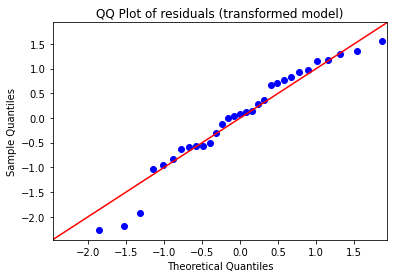

In [ ]:
fig = sm.qqplot(trees_df["transformed_residuals"], fit=True, line='45')
plt.title("QQ Plot of residuals (transformed model)")
plt.show()

Wykres heteroskedacity jest prawdopodobnie nieco gorszy niż wariant nieprzekształcony, co wskazuje, że transformacja może *nie* być prawidłowa (różni badacze danych wyciągnęliby inne wnioski). Chociaż więcej punktów danych leży na linii prostej, istnieje około 5 punktów danych, które odbiegają bardziej niż wcześniej wizualizowano. Jest to ważny punkt — pomimo tego, że robimy box-cox, aby przekształcić zmienną do normalności, co **nie** gwarantuje, że nasze reszty będą miały rozkład normalny. Bazując na założeniach regresji liniowej, które nakreśliliśmy, reszty po normalności są ważniejsze niż same dane po normalności. Mówiąc to, te punkty mogą wskazywać na *obserwacje odstające*, które omówimy dokładniej w następnym zeszycie.